In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# 1 - Context & Model Diagram Flow
---
The is related to a restaurant located at the South of Brasil.

This dataset is combining several variables from different nature, such as: Customer, Whether, Sales History, Competitors and more.

The idea behind is to aggregate on a singular `dataset.csv`, all the necessary information to predict the next day sales (VENDAS)

![MODEL FLOW](https://user-images.githubusercontent.com/8363610/93688721-3e95c180-fa9e-11ea-9d3f-1182bc0fc9d3.png)


# 2 - Evaluation 
---
RMSE (with or without cross validation)

MAE (with or without cross validation)

# 3 - Reading CSV

---

Here we are reading the dataset and adding a *df* variable

It is good to notice that the `dataset.csv` has passed through the **OneHotEncoding** technique

In [2]:
import warnings
import pandas as pd
warnings.filterwarnings("ignore")

df = pd.read_csv('dataset.csv')
pd.set_option('display.max_rows', 500)

# 4 - Pre processing the Dataset

---

Here we are adding some new columns which may increase the model perfomance

In [3]:
import math

def get_vendas_ontem(df):
    first_row = 1
    df_temp = df['VENDAS'].shift(1)
    df_temp[0:first_row] = df[0:first_row]['VENDAS']
    
    for i in range(len(df_temp)):
        row_value = df_temp[i]
        inner_index = i
        while row_value == 0 or math.isnan(row_value):
            inner_index = inner_index - 1
            row_value = df_temp[inner_index]

        df_temp[i] = row_value.round().astype(int)
    return df_temp

df.insert(loc=20, column='VENDAS_ONTEM', value=(get_vendas_ontem(df)))

df['DATA'] = (pd.to_datetime(df['DATA'], dayfirst=True))

# 5 - Removing Outliers

---

Here we are removing the records which are appearing less than 3% (the outliers)

In [4]:
df = df.query('VENDAS < 200 and VENDAS > 70')
df = df.query('FECHADO == 0 and ABERTO == 1')

# 6 - Dropping Columns

---

Here we are removing the columns that are ambiguos

In [5]:
import numpy as np

df = df.drop(columns=['FECHADO', 'ABERTO', 'DS', 'DATA_NAO_FESTIVA', 'BAIXA_TEMPORADA', 'SEMANA_DE_NAO_PAGAMENTO', 'NAO_FERIADO'])

# saving variable for later
all_columns = np.array(df.columns)

# 7 - LSTM Hypothesis
---
Since LSTM works well with time-series-like dataset, we will use it

## 7.1 - Permutation Importance

Here we are checking what are the most important features for the LSTM algorithm


In [6]:
import numpy as np
import eli5

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from eli5.sklearn import PermutationImportance

# creating feature dataset
features_to_drop_default = ['DATA', 'VENDAS']
features_to_drop_from_feature_analysis = ['SEMANA_PAGAMENTO', 'PRECIPITACAO']
features_to_drop_from_feature_importance = ['TEMPERATURA', 'POS_DATA_FESTIVA', 'FDS', 'VESPERA_DATA_FESTIVA', 'ALTA_TEMPORADA']
features_to_drop = features_to_drop_default + features_to_drop_from_feature_analysis + features_to_drop_from_feature_importance

# creating target dataset
outputs_to_drop = ['DATA', 'FDS', 'DATA_FESTIVA', 'VESPERA_DATA_FESTIVA', 'POS_DATA_FESTIVA', 'FERIADO', 'SEMANA_PAGAMENTO', 'ALTA_TEMPORADA', 'QTD_CONCORRENTES', 'PRECIPITACAO', 'TEMPERATURA', 'UMIDADE', 'VENDAS_ONTEM']

# columns considered by the model
leftovers = np.setdiff1d(all_columns, features_to_drop) 
X_lstm = df.drop(columns=features_to_drop)
y_lstm = df.drop(columns=outputs_to_drop)

# save features names
features = X_lstm.columns.values.tolist()

# shuffled and splitted into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.05, random_state=1, shuffle=False)

# feature scaling
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 7.2 - Feature Engineering

Here we are scaling / normalizing our features leftovers

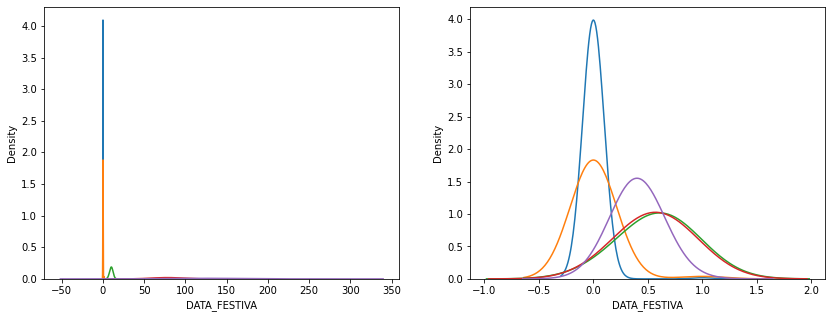

In [7]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt
import seaborn as sns

# plot scaling
scaled_X_train = pd.DataFrame(X_train, columns=leftovers)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 5))

for i in range(len(leftovers)):
    column = leftovers[i]
    sns.kdeplot(X_lstm[column], bw=1.5, ax=ax1)

for j in range(len(leftovers)):
    column = leftovers[j]
    sns.kdeplot(scaled_X_train[column], bw=1.5, ax=ax2)

plt.show()

## 7.3 - Model Creation, Fitting, Tunning & Prediction

Here we are creating our MLPRegressor model, tunning, fitting, predicting and ploting the results


RMSE: 18.61
MAE: 14.22
R2: -0.26


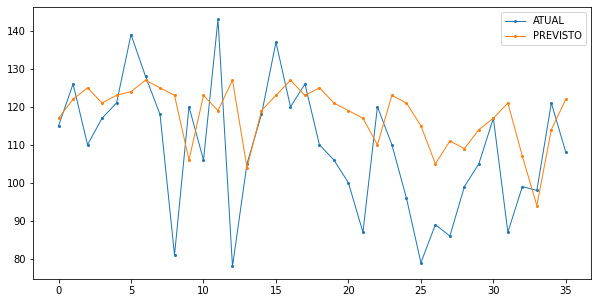

In [8]:
# imports
import seaborn as sns
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasRegressor

# reshape to 3D
train_X = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
train_y = np.array(y_train).reshape((y_train.shape[0], 1, y_train.shape[1]))
test_X = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# model
def base_model():
    lstm = Sequential()
    lstm.add(LSTM(190, return_sequences=True))
    lstm.add(Dropout(0.2))
    lstm.add(LSTM(190, return_sequences=True))
    lstm.add(Dropout(0.2))
    lstm.add(LSTM(190, return_sequences=False))
    lstm.add(Dropout(0.2))
    lstm.add(Dense(1))
    lstm.compile(loss='mean_squared_error', optimizer='adam')
    return lstm
lstm = KerasRegressor(build_fn=base_model)

# manual training
lstm.fit(train_X, train_y, epochs=200, batch_size=20, shuffle=False, verbose=False)
y_pred_lstm = lstm.predict(test_X).round().astype(int)
y_pred_lstm = y_pred_lstm.reshape((y_pred_lstm.shape[0], -1))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2])) # train_x shape?????
rmse = metrics.mean_squared_error(y_test, y_pred_lstm, squared=False)
mae = metrics.mean_absolute_error(y_test, y_pred_lstm)
print(f'RMSE: %.2f' % rmse)
print(f'MAE: %.2f' % mae)
print(f'R2: %.2f' % metrics.r2_score(y_test, y_pred_lstm))

# plot
df1 = pd.DataFrame({'ATUAL': y_test.values.flatten(), 'PREVISTO': y_pred_lstm.flatten()})
df1.plot(kind='line', figsize=(10, 5), linestyle='solid', linewidth=1, markersize=2, style="-o")
plt.show()

# 8 - GradientBoostingRegressor Hypothesis
---
Since GB works well with splitting the features and exploiting them, we will use it

## 8.1 - Permutation Importance

Here we are checking what are the most important features for the **GradientBoostingRegressor** algorithm


In [9]:
import numpy as np
import eli5

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingRegressor
from eli5.sklearn import PermutationImportance

################################################ 1st Round

# creating feature dataset
features_to_drop_default = ['DATA', 'VENDAS']
features_to_drop_from_feature_analysis = ['SEMANA_PAGAMENTO', 'PRECIPITACAO']
features_to_drop = features_to_drop_default + features_to_drop_from_feature_analysis 

# creating target dataset
outputs_to_drop = ['DATA', 'FDS', 'DATA_FESTIVA', 'VESPERA_DATA_FESTIVA', 'POS_DATA_FESTIVA', 'FERIADO', 'SEMANA_PAGAMENTO', 'ALTA_TEMPORADA', 'QTD_CONCORRENTES', 'PRECIPITACAO', 'TEMPERATURA', 'UMIDADE', 'VENDAS_ONTEM']

# columns considered by the model
leftovers = np.setdiff1d(all_columns, features_to_drop) 
X_gb = df.drop(columns=features_to_drop)
y_gb = df.drop(columns=outputs_to_drop)

# save features names
features = X_gb.columns.values.tolist()

# shuffled and splitted into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_gb, y_gb, test_size=0.05, random_state=1, shuffle=False)

# feature scaling
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# permutation importance
model = GradientBoostingRegressor()
model.fit(X_train, y_train)
perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=features)

################################################ 2nd Round

# creating feature dataset
features_to_drop_from_permutation = ['FDS', 'UMIDADE', 'TEMPERATURA', 'VESPERA_DATA_FESTIVA']
features_to_drop = features_to_drop_default + features_to_drop_from_feature_analysis + features_to_drop_from_permutation

# columns considered by the model
leftovers = np.setdiff1d(all_columns, features_to_drop) 
X_gb = df.drop(columns=features_to_drop)
y_gb = df.drop(columns=outputs_to_drop)

# save features names
features = X_gb.columns.values.tolist()

# shuffled and splitted into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_gb, y_gb, test_size=0.05, random_state=1, shuffle=False)

# feature scaling
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# permutation importance
nn = GradientBoostingRegressor()
nn.fit(X_train, y_train)
perm = PermutationImportance(nn, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=features)

################################################ 3rd Round
# creating feature dataset
features_to_drop_from_permutation_2nd_round = ['POS_DATA_FESTIVA']
features_to_drop = features_to_drop_default + features_to_drop_from_feature_analysis + features_to_drop_from_permutation + features_to_drop_from_permutation + features_to_drop_from_permutation_2nd_round

# columns considered by the model
leftovers = np.setdiff1d(all_columns, features_to_drop) 
X_gb = df.drop(columns=features_to_drop)
y_gb = df.drop(columns=outputs_to_drop)

# save features names
features = X_gb.columns.values.tolist()

# shuffled and splitted into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_gb, y_gb, test_size=0.05, random_state=1, shuffle=False)

# feature scaling
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# permutation importance
nn = GradientBoostingRegressor()
nn.fit(X_train, y_train)
perm = PermutationImportance(nn, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=features)

Weight,Feature
0.1350 ± 0.7636,VENDAS_ONTEM
0 ± 0.0000,QTD_CONCORRENTES
0 ± 0.0000,FERIADO
0 ± 0.0000,DATA_FESTIVA
-0.0026 ± 0.1631,ALTA_TEMPORADA


## 8.2 - Feature Engineering

Here we are scaling / normalizing our features leftovers

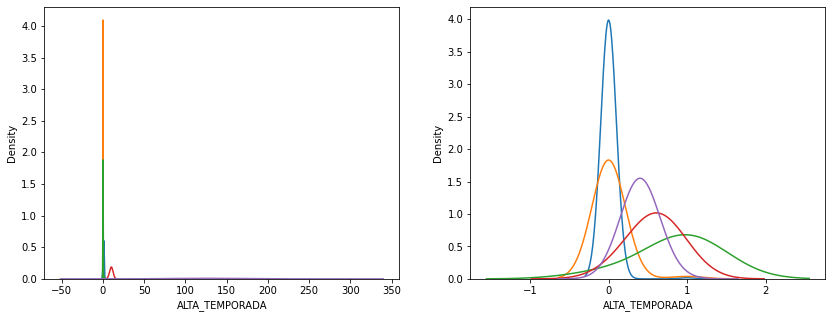

In [10]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

# plot scaling
scaled_X_train = pd.DataFrame(X_train, columns=leftovers)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 5))

for i in range(len(leftovers)):
    column = leftovers[i]
    sns.kdeplot(X_gb[column], bw=1.5, ax=ax1)

for j in range(len(leftovers)):
    column = leftovers[j]
    sns.kdeplot(scaled_X_train[column], bw=1.5, ax=ax2)

plt.show()

## 8.3 - Model Creation, Fitting, Tunning & Prediction 

Here we are creating our GradientBoostingRegressor model, tunning, fitting, predicting and ploting the results 

RMSE (cross validation): 18.02
MAE (cross validation): 14.11
RMSE: 19.70
MAE: 15.19
R2: -0.41


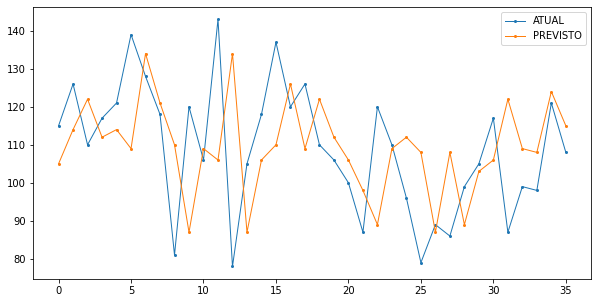

In [11]:
# imports
from sklearn.ensemble import GradientBoostingRegressor

# model
gb = GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=25,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=21, min_samples_split=16,
                          min_weight_fraction_leaf=0.0, n_estimators=139,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=1, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

# cross validation
scores_rmse = cross_val_score(gb, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
scores_mae = cross_val_score(gb, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
print(f'RMSE (cross validation): %.2f' % np.abs(scores_rmse).min())
print(f'MAE (cross validation): %.2f' % np.abs(scores_mae).min())

# manual training
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test).round().astype(int)
print(f'RMSE: %.2f' % metrics.mean_squared_error(y_test, y_pred_gb, squared=False))
print(f'MAE: %.2f' % metrics.mean_absolute_error(y_test, y_pred_gb))
print(f'R2: %.2f' % metrics.r2_score(y_test, y_pred_gb))

# plot
df1 = pd.DataFrame({'ATUAL': y_test.values.flatten(), 'PREVISTO': y_pred_gb.flatten()})
df1.plot(kind='line', figsize=(10, 5), linestyle='solid', linewidth=1, markersize=2, style="-o")
plt.show()

# 9 - MLPRegressor Hypothesis
---
Since MLP works well with several different features, we will use it

## 9.1 - Permutation Importance 

Here we are checking what are the most important features for the **MLPRegressor** algorithm


In [12]:
import numpy as np
import eli5

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPRegressor
from eli5.sklearn import PermutationImportance

################################################ 1st Round

# creating feature dataset
features_to_drop_default = ['DATA', 'VENDAS']
features_to_drop_from_feature_analysis = ['SEMANA_PAGAMENTO', 'PRECIPITACAO']
features_to_drop = features_to_drop_default + features_to_drop_from_feature_analysis 

# creating target dataset
outputs_to_drop = ['DATA', 'FDS', 'DATA_FESTIVA', 'VESPERA_DATA_FESTIVA', 'POS_DATA_FESTIVA', 'FERIADO', 'SEMANA_PAGAMENTO', 'ALTA_TEMPORADA', 'QTD_CONCORRENTES', 'PRECIPITACAO', 'TEMPERATURA', 'UMIDADE', 'VENDAS_ONTEM']

# columns considered by the model
leftovers = np.setdiff1d(all_columns, features_to_drop) 
X_mlp = df.drop(columns=features_to_drop)
y_mlp = df.drop(columns=outputs_to_drop)

# save features names
features = X_mlp.columns.values.tolist()

# shuffled and splitted into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_mlp, y_mlp, test_size=0.05, random_state=1, shuffle=False)

# feature scaling
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# permutation importance
model = MLPRegressor()
model.fit(X_train, y_train)
perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=features)

################################################ 2nd Round

# creating feature dataset
features_to_drop_from_permutation = ['QTD_CONCORRENTES', 'VESPERA_DATA_FESTIVA', 'FDS']
features_to_drop = features_to_drop_default + features_to_drop_from_feature_analysis + features_to_drop_from_permutation

# columns considered by the model
leftovers = np.setdiff1d(all_columns, features_to_drop) 
X_mlp = df.drop(columns=features_to_drop)
y_mlp = df.drop(columns=outputs_to_drop)

# save features names
features = X_mlp.columns.values.tolist()

# shuffled and splitted into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_mlp, y_mlp, test_size=0.05, random_state=1, shuffle=False)

# feature scaling
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# permutation importance
nn = MLPRegressor()
nn.fit(X_train, y_train)
perm = PermutationImportance(nn, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=features)

################################################ 3rd Round
# creating feature dataset
features_to_drop_from_permutation_2nd_round = ['ALTA_TEMPORADA']
features_to_drop = features_to_drop_default + features_to_drop_from_feature_analysis + features_to_drop_from_permutation + features_to_drop_from_permutation + features_to_drop_from_permutation_2nd_round

# columns considered by the model
leftovers = np.setdiff1d(all_columns, features_to_drop) 
X_mlp = df.drop(columns=features_to_drop)
y_mlp = df.drop(columns=outputs_to_drop)

# save features names
features = X_mlp.columns.values.tolist()

# shuffled and splitted into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_mlp, y_mlp, test_size=0.05, random_state=1, shuffle=False)

# feature scaling
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# permutation importance
nn = MLPRegressor()
nn.fit(X_train, y_train)
perm = PermutationImportance(nn, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=features)

Weight,Feature
0.2696 ± 0.0867,TEMPERATURA
0.1946 ± 0.1173,UMIDADE
0.1359 ± 0.1988,VENDAS_ONTEM
0.0303 ± 0.1725,POS_DATA_FESTIVA
0 ± 0.0000,FERIADO
0 ± 0.0000,DATA_FESTIVA


## 9.2 - Feature Engineering 

Here we are scaling / normalizing our features leftovers

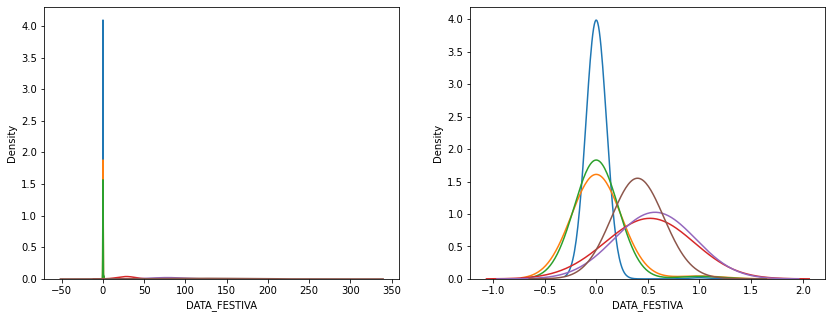

In [13]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

# plot scaling
scaled_X_train = pd.DataFrame(X_train, columns=leftovers)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 5))

for i in range(len(leftovers)):
    column = leftovers[i]
    sns.kdeplot(X_mlp[column], bw=1.5, ax=ax1)

for j in range(len(leftovers)):
    column = leftovers[j]
    sns.kdeplot(scaled_X_train[column], bw=1.5, ax=ax2)

plt.show()

## 9.3 - Model Creation, Fitting, Tunning & Prediction

Here we are creating our MLPRegressor model, tunning, fitting, predicting and ploting the results 

RMSE (cross validation): 17.45
MAE (cross validation): 13.92
RMSE: 19.53
MAE: 14.58
R2: -0.38


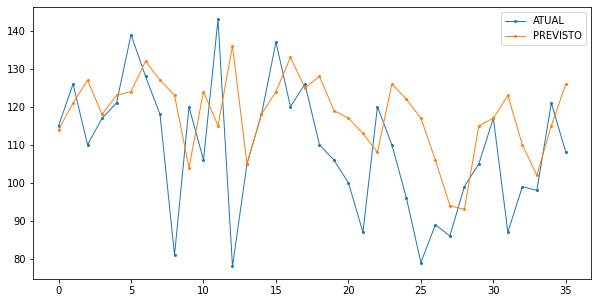

In [14]:
# imports
from sklearn.neural_network import MLPRegressor

# model
mlp = MLPRegressor(activation='identity', alpha=0.0001, batch_size=300, beta_1=0.9,
             beta_2=0.999, early_stopping=True, epsilon=1e-08,
             hidden_layer_sizes=(149), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=100,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=1, shuffle=False, solver='lbfgs',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=True)

# cross validation
scores_rmse = cross_val_score(mlp, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
scores_mae = cross_val_score(mlp, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
print(f'RMSE (cross validation): %.2f' % np.abs(scores_rmse).min())
print(f'MAE (cross validation): %.2f' % np.abs(scores_mae).min())

# manual training
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test).round().astype(int)
print(f'RMSE: %.2f' % metrics.mean_squared_error(y_test, y_pred_mlp, squared=False))
print(f'MAE: %.2f' % metrics.mean_absolute_error(y_test, y_pred_mlp))
print(f'R2: %.2f' % metrics.r2_score(y_test, y_pred_mlp))

# plot
df1 = pd.DataFrame({'ATUAL': y_test.values.flatten(), 'PREVISTO': y_pred_mlp.flatten()})
df1.plot(kind='line', figsize=(10, 5), linestyle='solid', linewidth=1, markersize=2, style="-o")
plt.show()

# 10 - Ensemble Technique

---

Lets combine our weak learners into a better one by joining all

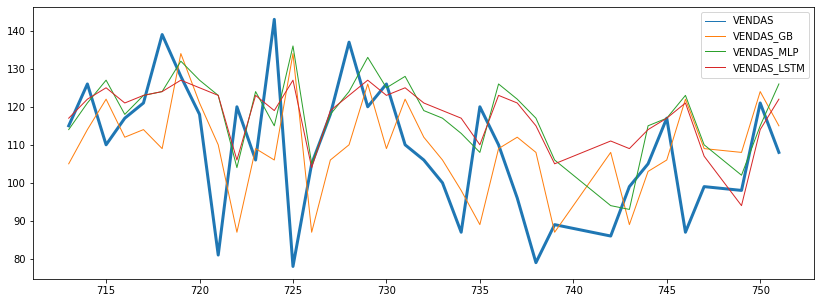

In [15]:
df_ensemble = pd.DataFrame()
df_ensemble.insert(loc=0, column='VENDAS', value=(y_test['VENDAS']))
df_ensemble.insert(loc=1, column='VENDAS_GB', value=(y_pred_gb))
df_ensemble.insert(loc=2, column='VENDAS_MLP', value=(y_pred_mlp))
df_ensemble.insert(loc=3, column='VENDAS_LSTM', value=(y_pred_lstm))

ax = df_ensemble.plot(figsize=(14, 5), linewidth=1)
for line in ax.get_lines():
    if line.get_label() == 'VENDAS':
        line.set_linewidth(3)
plt.show()

## 10.1 - Bagging 
---
Here we are using the previous models, to assert what is the prediction given a manual set of test parameters

In [16]:
# import joblib
# from keras.wrappers.scikit_learn import KerasRegressor

# joblib.dump(gb, 'GB.pkl')
# joblib.dump(mlp, 'MLP.pkl')

# gb_final_model = joblib.load('GB.pkl')
# mlp_final_model = joblib.load('MLP.pkl')

# gb_features = []
# gb_features.append(1) # ALTA_TEMPORADA
# gb_features.append(0) # DATA_FESTIVA
# gb_features.append(0) # FERIADO
# gb_features.append(13) # QTD_CONCORRENTES
# gb_features.append(100) # VENDAS_ONTEM
# gb_y_pred = gb.predict(scaler.transform([gb_features])).round().astype(int)[0]

# mlp_features = []
# mlp_features.append(0) # DATA_FESTIVA
# mlp_features.append(0) # FERIADO
# mlp_features.append(0) # POS_DATA_FESTIVA
# mlp_features.append(25) # TEMPERATURA
# mlp_features.append(55) # UMIDADE
# mlp_features.append(340) # VENDAS_ONTEM
# mlp_y_pred = mlp.predict(scaler.transform([mlp_features])).round().astype(int)[0]

# print(f'Amanha será vendido {(gb_y_pred + mlp_y_pred) / 2} almoços com estas condições')

# 11 - Questions


### why cross val scores gives nan with LSTM?
> 

### how to export / dump LSTM?
> 


### how to manage fit_transform vs transform in the predictions?
> 